In [1]:
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import xy
from rasterio.vrt import WarpedVRT
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy
from collections import OrderedDict

from shapely.geometry import Point

In [2]:
PLOTTING_PROJ = ccrs.PlateCarree()
with open('../data/proj.str', 'r') as proj_src:
    DIST_PROJ = proj_src.readline()

def geoax(figsize=(10, 5), **kwargs):
    f, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": PLOTTING_PROJ}, **kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    
    return f, ax

In [3]:
# read in the flow direction file
fdr = rio.open("../data/flow_direction.tif")
band = fdr.read(1, masked=True)


In [4]:
# band.data[band.data==1] = 3
# band.data[band.data==2] = 4
# band.data[band.data==4] = 5
# band.data[band.data==8] = 6
# band.data[band.data==16] = 7
# band.data[band.data==32] = 8
# band.data[band.data==64] = 1
# band.data[band.data==128] = 2

In [5]:
band.mask[band.data == 0] = True
band.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

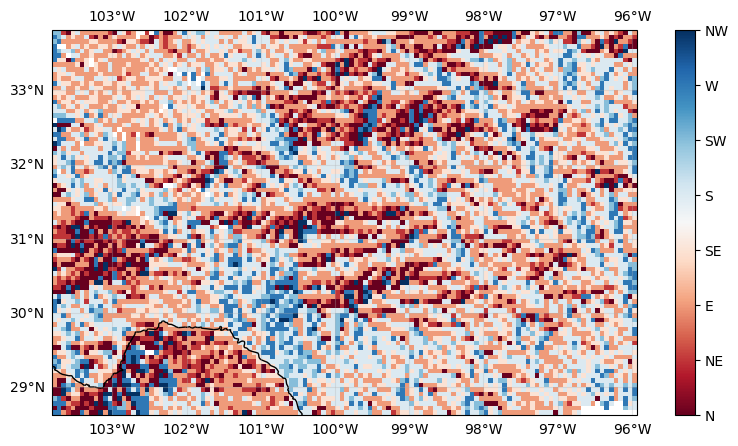

In [6]:
direction_mapping = OrderedDict()
direction_mapping[0]= 0
direction_mapping[1]= 3
direction_mapping[2]= 4
direction_mapping[4]= 5
direction_mapping[8]= 6
direction_mapping[16]= 7
direction_mapping[32]= 8
direction_mapping[64]= 1
direction_mapping[128]= 2
    
band_vicfmt = np.ma.MaskedArray(np.vectorize(direction_mapping.get)(band.data).astype(float), mask=band.mask)
# band_vicfmt = np.vectorize(direction_mapping.get)(band.data).astype(float)

f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='RdBu')
# im = ax.imshow(np.ones(band.data.shape)[band.data[0] is None], extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [7]:
band_vicfmt

masked_array(
  data=[[6.0, 6.0, 2.0, ..., 1.0, 5.0, 3.0],
        [7.0, 6.0, 5.0, ..., 3.0, 3.0, 2.0],
        [6.0, 7.0, 3.0, ..., 3.0, 2.0, 1.0],
        ...,
        [7.0, 7.0, 7.0, ..., 7.0, 4.0, 5.0],
        [1.0, 7.0, 1.0, ..., 6.0, 5.0, 5.0],
        [7.0, 7.0, 3.0, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=1e+20)

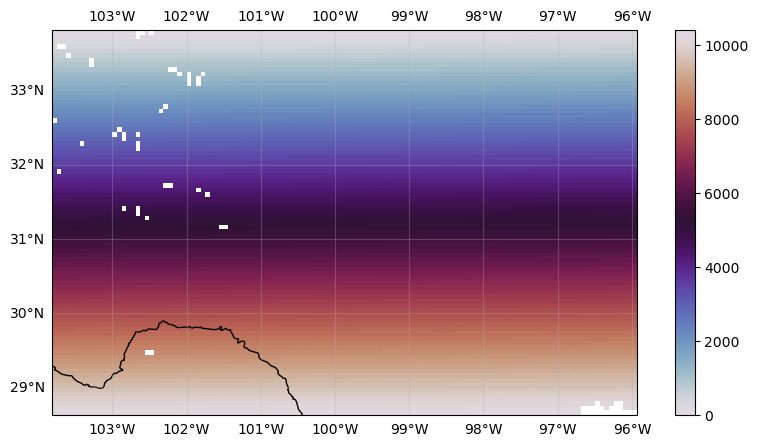

In [8]:
# create id of each cell
band_ids = np.full_like(band_vicfmt, np.nan)
_id = 0
for i in np.arange(band_vicfmt.shape[0]):
    for j in np.arange(band_vicfmt.shape[1]):
        if band_vicfmt[i][j] is not np.ma.masked:
            band_ids[i][j] = _id
            _id += 1
# band_ids = np.ma.MaskedArray(band_ids, mask=band)

band_ids
f, ax = geoax()
im = ax.imshow(band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


<AxesSubplot:>

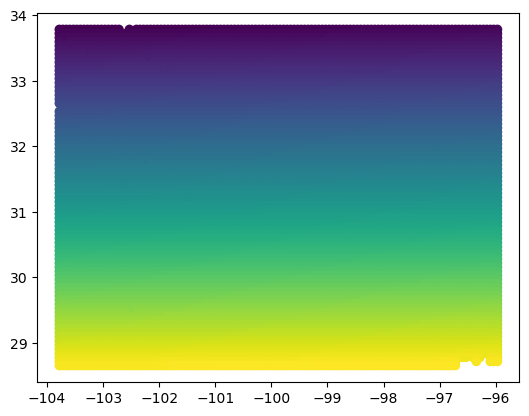

In [9]:
# create nodes
# extract x-y points
xs, _ = xy(fdr.transform, 0, np.arange(fdr.width))
_, ys = xy(fdr.transform, np.arange(fdr.height), 9)

XX, YY = np.meshgrid(xs, ys)

# create gdf
grid_pts = gpd.GeoDataFrame(data={'id': band_ids.flatten()}, geometry=[Point(x, y) for x, y in zip(XX.flatten(), YY.flatten())], crs='EPSG:4326')
grid_pts['to_id'] = np.nan

grid_pts.plot('id')


0.0 (0, 0) SW  > | > 247.0 (1, -1)
1.0 (0, 1) SW  > | > 123.0 (1, 0)
2.0 (0, 2) NE  > | > 10282.0 (-1, 3)
3.0 (0, 3) N  > | > 10282.0 (-1, 3)
4.0 (0, 4) SE  > | > 128.0 (1, 5)
5.0 (0, 5) S  > | > 128.0 (1, 5)
6.0 (0, 6) E  > | > 7.0 (0, 7)
7.0 (0, 7) E  > | > 8.0 (0, 8)
8.0 (0, 8) E  > | > 9.0 (0, 9)
9.0 (0, 9) E  > | > 10.0 (0, 10)
10.0 (0, 10) E  > | > 11.0 (0, 11)
11.0 (0, 11) E  > | > 12.0 (0, 12)
12.0 (0, 12) NE  > | > 10292.0 (-1, 13)
13.0 (0, 13) N  > | > 10292.0 (-1, 13)
14.0 (0, 14) S  > | > 137.0 (1, 14)
15.0 (0, 15) SE  > | > 139.0 (1, 16)
16.0 (0, 16) NE  > | > 10296.0 (-1, 17)
17.0 (0, 17) E  > | > -- (0, 18)
18.0 (0, 20) NE  > | > 10300.0 (-1, 21)
19.0 (0, 22) W  > | > -- (0, 21)
20.0 (0, 23) E  > | > 21.0 (0, 24)
21.0 (0, 24) N  > | > 10303.0 (-1, 24)
22.0 (0, 25) N  > | > 10304.0 (-1, 25)
23.0 (0, 26) E  > | > 24.0 (0, 27)
24.0 (0, 27) S  > | > 149.0 (1, 27)
25.0 (0, 28) W  > | > 24.0 (0, 27)
26.0 (0, 29) SE  > | > 152.0 (1, 30)
27.0 (0, 30) S  > | > 152.0 (1, 30)
28.0 

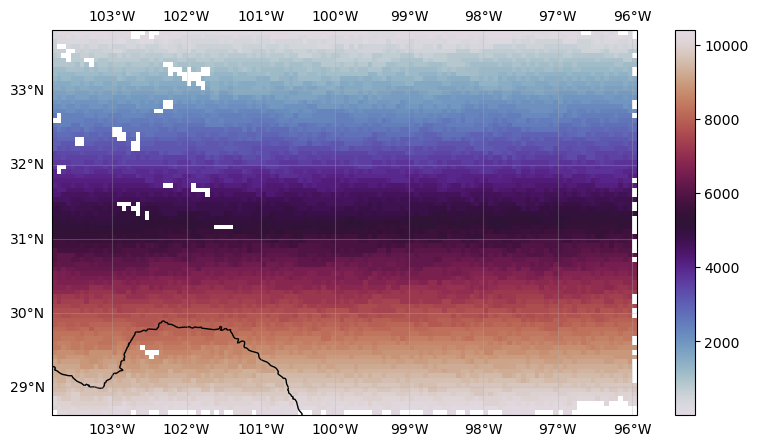

In [10]:
# create id of each cell
operations = {
    1: [-1, 0],  # N
    2: [-1, 1],  # NE
    3: [0, 1],   # E
    4: [1, 1],   # SE
    5: [1, 0],   # S
    6: [1, -1],  # SW
    7: [0, -1],  # W
    8: [-1, -1], # NW
}
directions = {
    1: "N",
    2: "NE",
    3: "E",
    4: "SE",
    5: "S",
    6: "SW",
    7: "W",
    8: "NW"
}

to_band_ids = np.full_like(band_vicfmt, np.nan)
for x in np.arange(band_vicfmt.shape[0]):   
    for y in np.arange(band_vicfmt.shape[1]):  
        if band_vicfmt[x][y] is not np.ma.masked:
            direction = band_vicfmt[x][y]
            op = operations[direction]
            new_x, new_y = x + op[0], y + op[1]
            if new_x < band_ids.shape[0] and new_y < band_ids.shape[1]:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", band_ids[new_x, new_y], (new_x, new_y))
                to_band_ids[x, y] = band_ids[new_x, new_y]
            else:
                print(band_ids[x, y], (x, y), directions[direction], " > | >", np.nan, (new_x, new_y))
                to_band_ids[x, y] = np.nan


# to_band_ids = np.ma.MaskedArray(to_band_ids, mask=band)

to_band_ids
f, ax = geoax()
im = ax.imshow(to_band_ids, extent=plotting_extent(fdr), cmap='twilight')
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im)


In [11]:
grid_pts['to_id'] = to_band_ids.flatten()

grid_pts.dropna(inplace=True)

grid_pts.head()

,id,geometry,to_id
0,0.0,POINT (-103.78125 33.78125),247.0
1,1.0,POINT (-103.71875 33.78125),123.0
2,2.0,POINT (-103.65625 33.78125),10282.0
3,3.0,POINT (-103.59375 33.78125),10282.0
4,4.0,POINT (-103.53125 33.78125),128.0


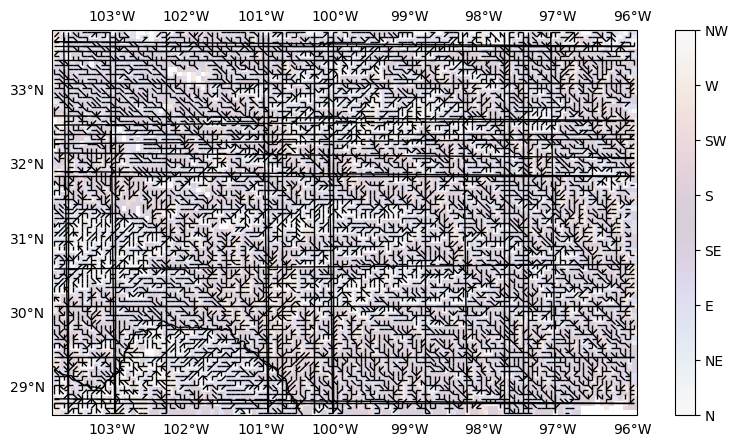

In [12]:
f, ax = geoax()
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

gl = ax.gridlines(alpha=0, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

In [13]:
root

id                             10390.0
geometry    POINT (-96.84375 28.65625)
to_id                          10391.0
Name: 10443, dtype: object

Lets import the reservoir locations

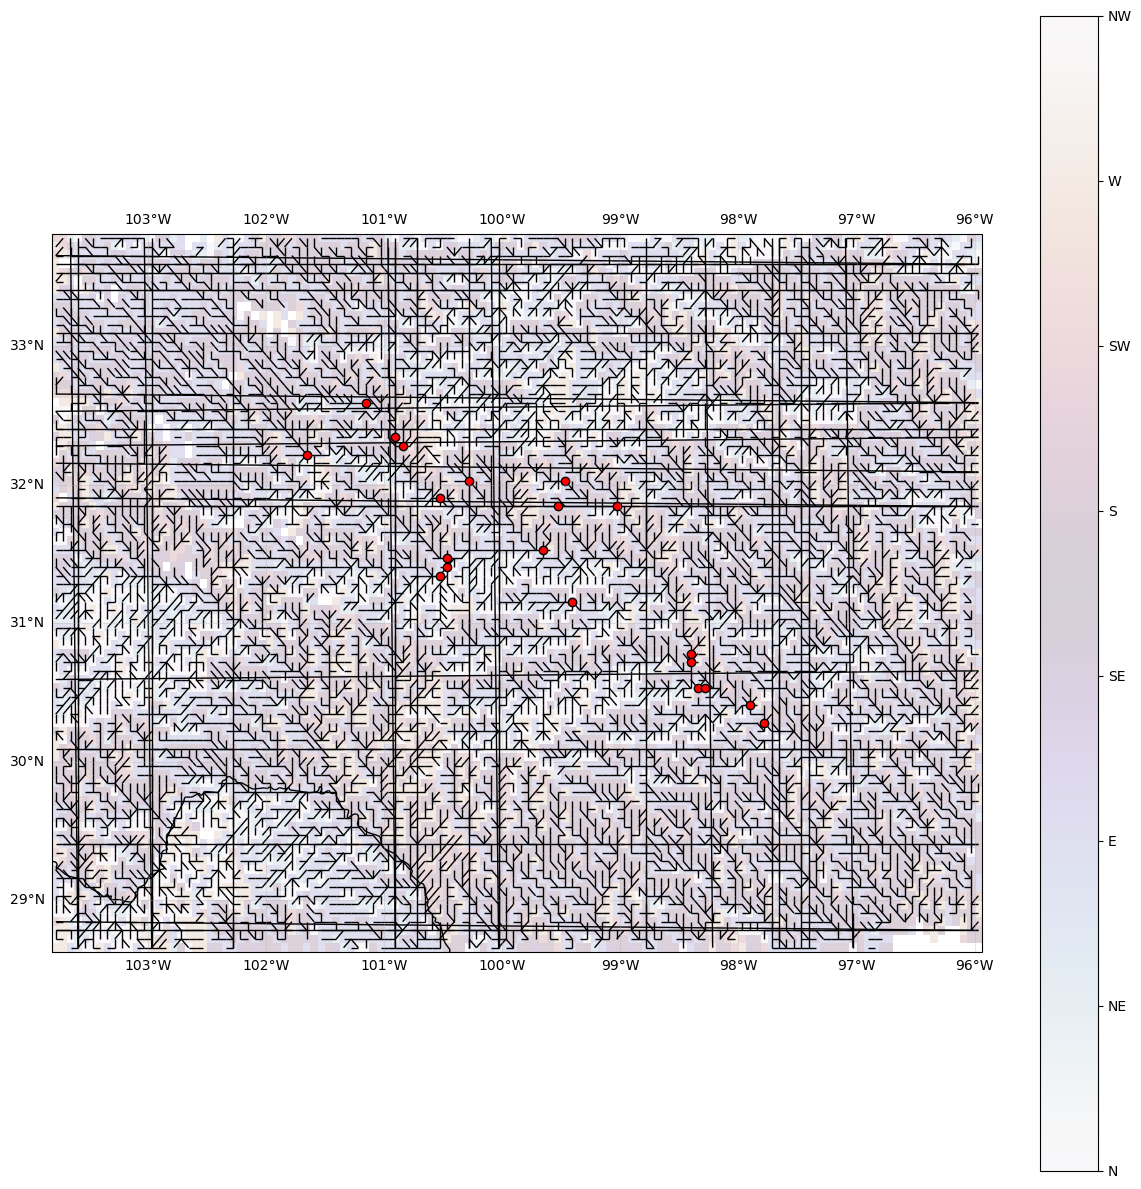

In [14]:
reservoirs_fn = "../data/selected_reservoirs/selected_reservoirs.gpkg"
reservoirs = gpd.read_file(reservoirs_fn)
reservoirs
reservoirs_to_join = reservoirs[['DAM_NAME', 'LONG', 'LAT', 'geometry']].rename({
    'DAM_NAME': 'name',
    'LONG': 'lon',
    'LAT': 'lat'
}, axis=1)

grid_pts_joined_stns = grid_pts.to_crs(DIST_PROJ).sjoin_nearest(reservoirs_to_join.to_crs(DIST_PROJ), how='left', distance_col='dist [m]').to_crs('epsg:4326')

grid_pts_joined_stns['min_dist'] = grid_pts_joined_stns.groupby('name')['dist [m]'].transform('min')
grid_pts_joined_stns.loc[grid_pts_joined_stns['dist [m]'] != grid_pts_joined_stns['min_dist'], ['index_right', 'name', 'lon', 'lat', 'dist [m]', 'min_dist']] = np.nan

grid_pts_joined_stns

# plot on top of previous plot
f, ax = geoax(figsize=(15, 15))
im = ax.imshow(band_vicfmt, extent=plotting_extent(fdr), cmap='twilight', alpha=0.2)

# save the root index
root = None
# Arrows
for i, row in grid_pts.iterrows():
    from_loc = row['geometry']
    try:
        to_loc = grid_pts.loc[grid_pts['id'] == row['to_id']].iloc[0]['geometry']
    except IndexError:
        to_loc = from_loc
        root = row

    x, y = from_loc.x, from_loc.y
    dx, dy = to_loc.x - x, to_loc.y - y

    WIDTH = 0.0
    ax.arrow(x, y, dx, dy, width=WIDTH, head_width=1*WIDTH, head_length=1*WIDTH)

grid_pts_joined_stns.dropna().plot(ax=ax, fc='red', ec='k')

gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.right_labels = False
cbar = f.colorbar(im, ticks=[1, 2, 3, 4, 5, 6, 7, 8])
cbar.ax.set_yticklabels(["N", "NE", "E", "SE", "S", "SW", "W", "NW"]);

now we need a function that can (1) join two reservoir locations based on the network we have. (2) assign the length of travel by summing the length between the points

In [15]:
# %load_ext autoreload
# %autoreload 1
# # from regulation.regulation import *
# %aimport regulation
# Reservoir = regulation.regulation.Reservoir

In [16]:
root

id                             10390.0
geometry    POINT (-96.84375 28.65625)
to_id                          10391.0
Name: 10443, dtype: object

In [19]:
grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)
stations = grid_pts_joined_stns.dropna()
stations

dist = lambda left_pt, right_pt: np.sqrt((left_pt.x-right_pt.x)**2 + (left_pt.y-right_pt.y)**2)

network = OrderedDict()
for i, stn in stations.iterrows():
    # r = Reservoir()
    # r.name = stn['name']
    name = stn['name']
    # r.id = stn['index_right']
    id = stn['index_right']
    length = 0
    
    if id not in network:
        network[id] = OrderedDict([
            ('network', []),
            ('lengths', [])
        ])

    current_id = stn['id']
    while True:
        current_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==current_id]
        if len(current_node) == 0:
            break
        next_id = current_node['to_id'].iloc[0]
        next_node = grid_pts_joined_stns.loc[grid_pts_joined_stns['id']==next_id]
        # print("\n\n\n", current_node['geometry'], next_node['geometry'])
        if len(next_node) > 0:
            length += dist(current_node['geometry'].iloc[0], next_node['geometry'].iloc[0])
        if not np.isnan(current_node['index_right'].iloc[0]):
            network[id]['network'].append(current_node['index_right'].iloc[0])
            network[id]['lengths'].append(length)

        if current_id == root['id']:
            break
        
        current_id = next_id


# in_network

In [20]:
network

OrderedDict([(13.0,
              OrderedDict([('network',
                            [13.0, 14.0, 0.0, 2.0, 7.0, 8.0, 9.0, 11.0, 12.0]),
                           ('lengths',
                            [5858.294151664702,
                             58686.759893909446,
                             141029.98883246997,
                             248327.66169601024,
                             448056.6219620295,
                             454985.62879319355,
                             480239.5547444181,
                             546531.1606895545,
                             574655.6027842683])])),
             (14.0,
              OrderedDict([('network',
                            [14.0, 0.0, 2.0, 7.0, 8.0, 9.0, 11.0, 12.0]),
                           ('lengths',
                            [6930.768303474021,
                             89273.99724203453,
                             196571.6701055748,
                             396300.63037159416,
                

In [21]:
# convert this network to a stream network

from shapely.geometry import LineString, Point
try:
    from itertools import pairwise
except:
    from itertools import tee

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)

grid_pts_joined_stns = grid_pts_joined_stns.to_crs(DIST_PROJ)

from_id = []
to_id = []
from_name = []
to_name = []
geoms = []
lengths = []

for id in network:
    downstreams = network[id]['network']
    link_lengths = network[id]['lengths']
    
    # print(downstreams, link_lengths)

    for id_pair, length in zip(pairwise(downstreams), link_lengths[1:]):  # the first element of `link_lengths` is garbage value. It is the distance of a single link
        # print(id_pair, length)
        start_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[0]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)
        end_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id_pair[1]].to_crs('epsg:4326').iloc[0]  # Get the points in EPSG:4326 CRS (lat-long)

        link = LineString([Point(pt.x, pt.y) for pt in (start_res.geometry, end_res.geometry)])

        geoms.append(link)
        from_id.append(id_pair[0])
        to_id.append(id_pair[1])
        from_name.append(start_res['name'])
        to_name.append(end_res['name'])
        lengths.append(length)

    # current_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==id].iloc[0]
    # pts = []
    # for downstream_res_id in downstreams:
    #     downstream_res = grid_pts_joined_stns.loc[grid_pts_joined_stns['index_right']==downstream_res_id].to_crs('epsg:4326').iloc[0]
    #     pts.append(downstream_res.geometry)

    # if len(pts) == 1:
    #     pts.append(pts[0])

    # link = LineString([Point(pt.x, pt.y) for pt in pts])
    # geoms.append(link)
    # names.append(current_res['name'])
    # ids.append(current_res.index_right)
    # lengths.append(link_lengths[-1])


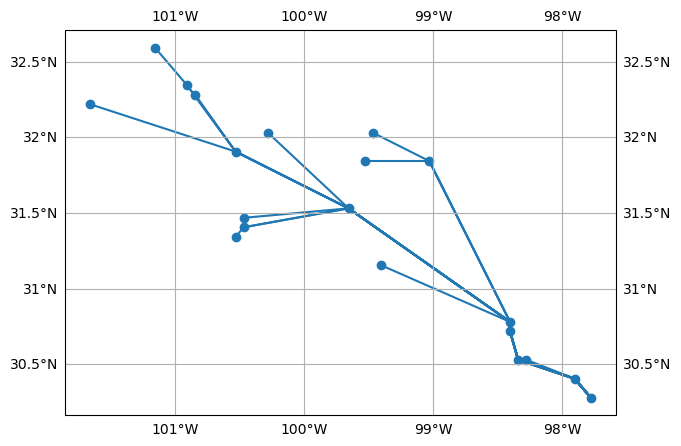

In [22]:
res_network = gpd.GeoDataFrame(data={
    'from_id': from_id,
    'to_id': to_id,
    'from_name': from_name,
    'to_name': to_name,
    'geometry': geoms,
    'length': lengths
})

f, ax = geoax()
res_network.plot(ax=ax)
grid_pts_joined_stns.dropna().to_crs('epsg:4326').plot(marker='o', ax=ax)

ax.gridlines(draw_labels=True)

In [23]:
res_network.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   from_id    99 non-null     float64 
 1   to_id      99 non-null     float64 
 2   from_name  99 non-null     object  
 3   to_name    99 non-null     object  
 4   geometry   99 non-null     geometry
 5   length     99 non-null     float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 4.8+ KB


In [24]:
# Save `res_network` for further use
save_fn = "../data/reservoir_network/reservoir_network.shp"  # even though .shp is not ideal, landlab uses this format to initialize. Create an issue in landlab.io?
res_network.to_file(save_fn)

In [26]:
grid_pts_joined_stns.dropna().to_crs('epsg:4326').to_file(save_fn.replace('reservoir_network', 'reservoir_network_pts'))

/home/pdas47/courses/cuahsi_landlab/project/ReservoirNetwork/.condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.
